# Volume budget

Following procedure provided in ECCO tutorial: https://ecco-v4-python-tutorial.readthedocs.io/ECCO_v4_Volume_budget_closure.html

In [1]:
## import required packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import s3fs
from datetime import timedelta

## import ECCO utils
import sys
sys.path.append('/Users/mzahn/github_others/ECCOv4-py')
import ecco_v4_py as ecco

In [2]:
import warnings
#ignore by message
warnings.filterwarnings("ignore", message="overflow encountered in divide")
warnings.filterwarnings("ignore", message="Sending large graph")

### Open geometry file for HH

In [3]:
# First open geometry file for HH field
grid_ds = xr.open_dataset("~/efs-mount-point/example_sassie_netcdfs/GRID_GEOMETRY_SASSIE_HH_V1R1_NATIVE_LLC1080.nc")

### Open 2D `ETAN` snapshots

In [4]:
# initalize s3 file system
s3 = s3fs.S3FileSystem(anon=False)
etan_monthly_list = s3.glob('s3://ecco-processed-data/SASSIE/N1/HH/PICKUPS/ETAN*.nc')

In [5]:
# function to create urls from s3 bucket path to be used for opening files
def create_s3_url(file_list):
    file_list_url = []
    for i in range(len(file_list)):
        file_list_url.append('s3://' + file_list[i])
    return file_list_url

In [6]:
# create urls for ETAN snapshots
etan_monthly_urls = create_s3_url(etan_monthly_list)

In [12]:
# iterate through remote files to create a fileset
fileset = [s3.open(file) for file in etan_monthly_urls]

# open on local ec2
etan_monthly_snaps = xr.open_mfdataset(fileset)

In [11]:
# see what dates we have for snapshots
ecco_monthly_snaps.time.values

array(['2014-01-04T12:00:00.000000000', '2014-01-07T12:00:00.000000000',
       '2014-03-05T12:00:00.000000000', '2014-03-30T12:00:00.000000000',
       '2014-04-24T12:00:00.000000000', '2014-05-19T12:00:00.000000000',
       '2014-07-08T12:00:00.000000000'], dtype='datetime64[ns]')

In [13]:
# each snapshot is 25 days apart
# select dates where we have continuous 25-day snapshots (i.e., remove the first 2 snapshots and the last one)
etan_monthly_snaps = ecco_monthly_snaps.isel(time=slice(2,6))

print(etan_monthly_snaps.time.values)

['2014-03-05T12:00:00.000000000' '2014-03-30T12:00:00.000000000'
 '2014-04-24T12:00:00.000000000' '2014-05-19T12:00:00.000000000']


#### Fix snapshot times

In [14]:
# add 12 hours back to timestamp (I incorrectly removed 12 hours with the assumption that it was the same processing as the model granules)
etan_monthly_snaps['time'] = etan_monthly_snaps.time.values + np.timedelta64(12,'h')

In [15]:
etan_monthly_snaps.time.values

array(['2014-03-06T00:00:00.000000000', '2014-03-31T00:00:00.000000000',
       '2014-04-25T00:00:00.000000000', '2014-05-20T00:00:00.000000000'],
      dtype='datetime64[ns]')

### Open 3D model fields

In [16]:
# function to open zarr store with a provided s3 bucket path

def open_zarr_store(s3_path):
    # initalize s3 file system
    s3 = s3fs.S3FileSystem(anon=False)

    # define location of zarr store and open
    store = s3fs.S3Map(root=s3_path, s3=s3, check=False)
    zarr_store = xr.open_zarr(store)
    
    return zarr_store

`UVELMASS` and `VVELMASS` are `UVEL` and `VVEL` multiplied by the fraction of the grid cell height that is open grid cell face across which the volume transport occurs.

In [17]:
# open oceFWflx zarr store
oceFWflx_zarr = open_zarr_store('s3://ecco-processed-data/SASSIE/N1/HH/ZARR/oceFWflx_AVG_DAILY.ZARR/')

# open WVELMASS zarr store
WVELMASS_zarr = open_zarr_store('s3://ecco-processed-data/SASSIE/N1/HH/ZARR/WVELMASS_AVG_DAILY.ZARR/')

# open UVELMASS zarr store
UVELMASS_zarr = open_zarr_store('s3://ecco-processed-data/SASSIE/N1/HH/ZARR/UVELMASS_AVG_DAILY.ZARR/')

# open VVELMASS zarr store
VVELMASS_zarr = open_zarr_store('s3://ecco-processed-data/SASSIE/N1/HH/ZARR/VVELMASS_AVG_DAILY.ZARR/')

#### Look at a few examples

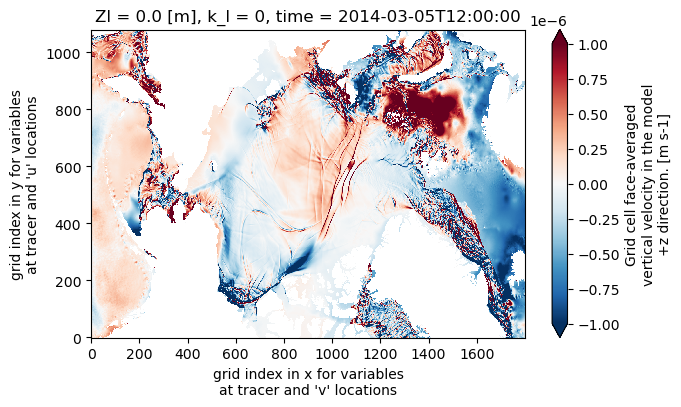

In [18]:
WVELMASS_zarr.isel(k_l=0).sel(time='2014-03-05').WVELMASS.plot(vmin=-1e-6,vmax=1e-6,cmap='RdBu_r',figsize=[7,4]);

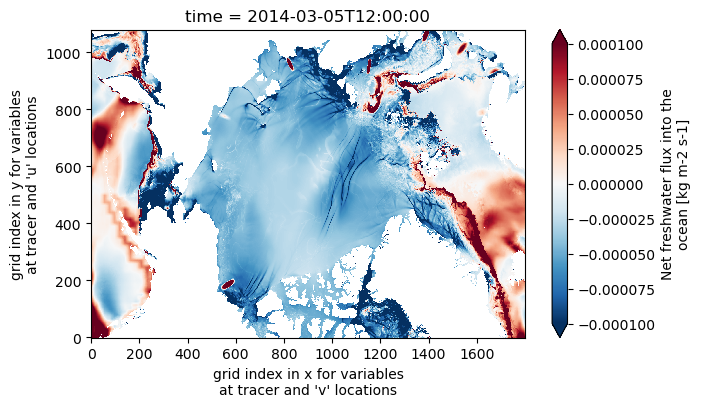

In [19]:
oceFWflx_zarr.sel(time='2014-03-05').oceFWflx.plot(vmin=-1e-4,vmax=1e-4,cmap='RdBu_r',figsize=[7,4]);

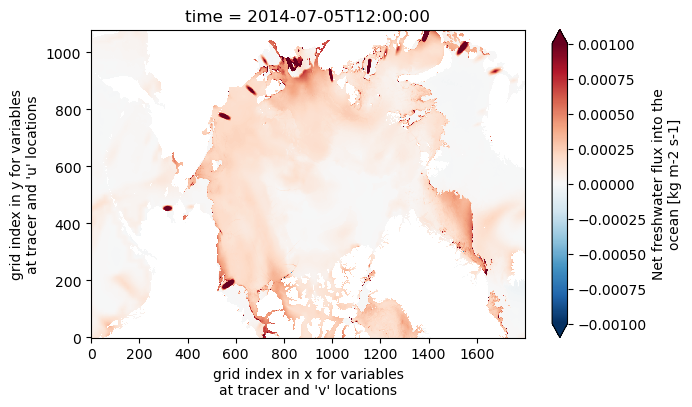

In [20]:
oceFWflx_zarr.sel(time='2014-07-05').oceFWflx.plot(vmin=-1e-3,vmax=1e-3,cmap='RdBu_r',figsize=[7,4]);

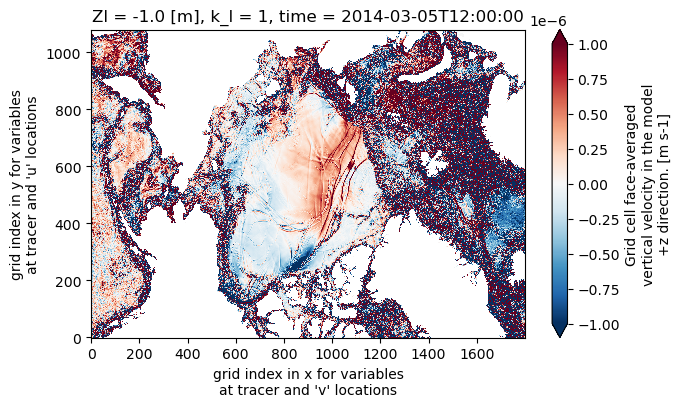

In [21]:
WVELMASS_zarr.isel(k_l=1).sel(time='2014-03-05').WVELMASS.plot(vmin=-1e-6,vmax=1e-6,cmap='RdBu_r',figsize=[7,4]);

#### Subtract the mean

Start with oceFWflx

In [22]:
# open one day for oceFWflx
oceFWflx_tmp = oceFWflx_zarr.sel(time='2014-03-05').oceFWflx[0]

In [23]:
# remove land from area field
area_tmp = grid_ds.rAc * grid_ds.maskC[0]

In [24]:
# obtain weights
weights = area_tmp / area_tmp.sum()

In [25]:
# calculate average oceFWflx for that day
oceFWflx_avg = (oceFWflx_tmp * weights).sum().compute()

In [26]:
oceFWflx_avg.values

array(-2.46228958e-05)

Do the same for WVELMASS

In [27]:
WVELMASS_tmp = WVELMASS_zarr.sel(time='2014-03-05').WVELMASS[0]
area_tmp = grid_ds.rAc * grid_ds.maskC[0]
weights = area_tmp / area_tmp.sum()
WVELMASS_avg = (WVELMASS_tmp * weights).sum().compute()

In [28]:
WVELMASS_avg.values

array(-2.36110882e-06)

Now plot after removing the mean

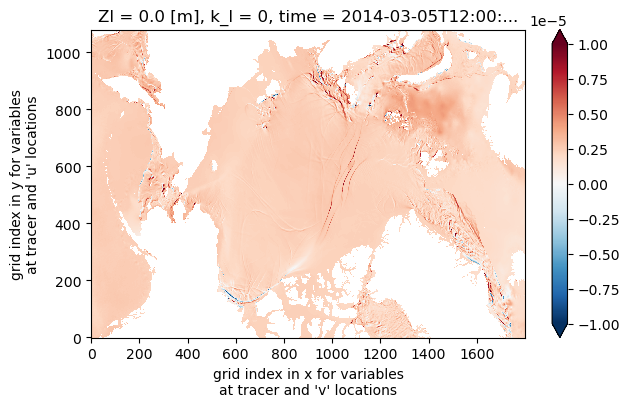

In [29]:
(WVELMASS_tmp.isel(k_l=0) - WVELMASS_avg).plot(vmin=-1e-5,vmax=1e-5,cmap='RdBu_r',figsize=[7,4])

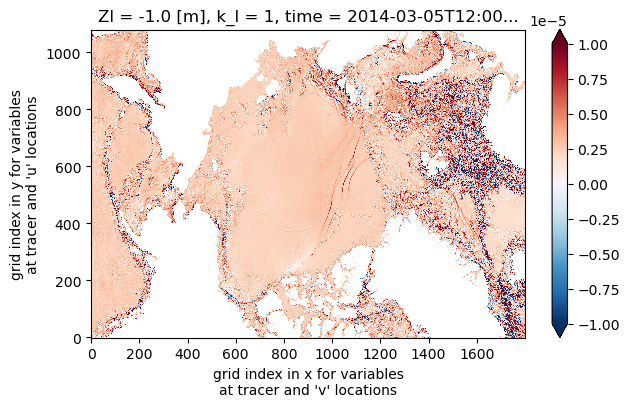

In [30]:
(WVELMASS_tmp.isel(k_l=1) - WVELMASS_avg).plot(vmin=-1e-5,vmax=1e-5,cmap='RdBu_r',figsize=[7,4])

### Select one 25 day period for each of the model granules between snapshots

#### (1) `oceFWflx`

In [33]:
# select days between pickup file dates
oceFWflx_slice = oceFWflx_zarr.sel(time=slice(etan_monthly_snaps.time.values[0], etan_monthly_snaps.time.values[1]))

# double check dates
print(f"snapshot start and end: {etan_monthly_snaps.time.values[0:2]}")
print(f"\noceFWflx start: {oceFWflx_slice.time.values[0]}")
print(f"oceFWflx end:   {oceFWflx_slice.time.values[-1]}")

snapshot start and end: ['2014-03-06T00:00:00.000000000' '2014-03-31T00:00:00.000000000']

oceFWflx start: 2014-03-06T12:00:00.000000000
oceFWflx end:   2014-03-30T12:00:00.000000000


In [34]:
# take mean for single 25 day slice
oceFWflx_slice_mean = oceFWflx_slice.oceFWflx.mean('time').compute()

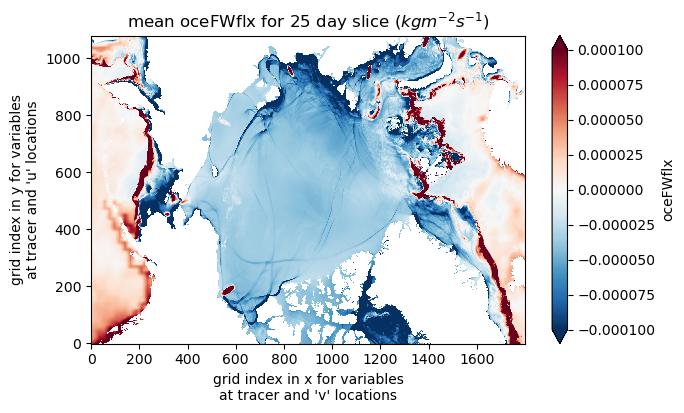

In [35]:
# plot mean oceFWflx
oceFWflx_slice_mean.plot(vmin=-1e-4,vmax=1e-4,cmap='RdBu_r',figsize=[7,4]);
plt.title("mean oceFWflx for 25 day slice ($kg m^{-2} s^{-1}$)");

In [36]:
# take mean over an entire year (2019) - we will use this later in the notebook
oceFWflx_slice_b = oceFWflx_zarr.sel(time='2019')
oceFWflx_slice_meanB = oceFWflx_slice_b.oceFWflx.mean('time').compute()

#### (2) `WVELMASS`

In [37]:
# select days between pickup file dates for 25 day period
WVELMASS_slice = WVELMASS_zarr.sel(time=slice(etan_monthly_snaps.time.values[0], etan_monthly_snaps.time.values[1]))

# double check dates
print(f"snapshot start and end: {etan_monthly_snaps.time.values[0:2]}")
print(f"\nWVELMASS_slice start: {WVELMASS_slice.time.values[0]}")
print(f"WVELMASS_slice end:   {WVELMASS_slice.time.values[-1]}")

snapshot start and end: ['2014-03-06T00:00:00.000000000' '2014-03-31T00:00:00.000000000']

WVELMASS_slice start: 2014-03-06T12:00:00.000000000
WVELMASS_slice end:   2014-03-30T12:00:00.000000000


In [133]:
# take mean for single 25 day slice
WVELMASS_slice_mean = WVELMASS_slice.WVELMASS.mean('time').compute()

#### (3) `UVELMASS`

In [38]:
# select days between pickup file dates for 25 day period
UVELMASS_slice = UVELMASS_zarr.sel(time=slice(etan_monthly_snaps.time.values[0], etan_monthly_snaps.time.values[1]))

# double check dates
print(f"snapshot start and end: {etan_monthly_snaps.time.values[0:2]}")
print(f"\nUVELMASS_slice start: {UVELMASS_slice.time.values[0]}")
print(f"UVELMASS_slice end:   {UVELMASS_slice.time.values[-1]}")

snapshot start and end: ['2014-03-06T00:00:00.000000000' '2014-03-31T00:00:00.000000000']

UVELMASS_slice start: 2014-03-06T12:00:00.000000000
UVELMASS_slice end:   2014-03-30T12:00:00.000000000


In [39]:
# take mean for single 25 day slice
UVELMASS_slice_mean = UVELMASS_slice.UVELMASS.mean('time').compute()

#### (4) `VVELMASS`

In [40]:
# select days between pickup file dates for 25 day period
VVELMASS_slice = VVELMASS_zarr.sel(time=slice(etan_monthly_snaps.time.values[0], etan_monthly_snaps.time.values[1]))

# double check dates
print(f"snapshot start and end: {etan_monthly_snaps.time.values[0:2]}")
print(f"\nVVELMASS_slice start: {VVELMASS_slice.time.values[0]}")
print(f"VVELMASS_slice end:   {VVELMASS_slice.time.values[-1]}")

snapshot start and end: ['2014-03-06T00:00:00.000000000' '2014-03-31T00:00:00.000000000']

VVELMASS_slice start: 2014-03-06T12:00:00.000000000
VVELMASS_slice end:   2014-03-30T12:00:00.000000000


In [41]:
# take mean for single 25 day slice
VVELMASS_slice_mean = VVELMASS_slice.VVELMASS.mean('time').compute()

***

### Calculate $\eta$ time tendency

Calculate the monthly-averaged time tendency of `ETAN` by differencing monthly `ETAN` snapshots. Subtract the numpy arrays $\eta$(t+1) - $\eta$(t). This operation gives us $\Delta$ `ETAN` / $\Delta$ t (month) records.

In [42]:
num_months = len(etan_monthly_snaps.time)
G_total_tendency_month = \
    etan_monthly_snaps.ETAN.isel(time=range(1,num_months)).values - \
    etan_monthly_snaps.ETAN.isel(time=range(0,num_months-1)).values

# The result is a numpy array of 3 months between snapshots
print('shape of G_total_tendency_month: ', G_total_tendency_month.shape)

shape of G_total_tendency_month:  (3, 1080, 1800)


In [45]:
# convert numpy array back to xarray

# use array with ETAN snaps as a template data array
tmp = etan_monthly_snaps.isel(time=slice(1,4)).ETAN.copy(deep=True)
tmp.values = G_total_tendency_month
tmp.name = 'G_total_tendency_month'
G_total_tendency_month = tmp

print('time of first array of G_total_tendency_month:');
print(G_total_tendency_month.time[0].values)

time of first array of G_total_tendency_month:
2014-03-31T00:00:00.000000000


Now convert $\Delta$ `ETAN` / $\Delta$ t (month) to $\Delta$ `ETAN` / $\Delta$ t (seconds) by dividing by the number of seconds in each month.

In [46]:
# calculate number of seconds over 25 days
num_sec_25days = 3600*24*25
print(num_sec_25days)

2160000


In [47]:
# and just double check
secs_per_snap = (etan_monthly_snaps.time[1:].values - \
etan_monthly_snaps.time[0:-1].values).astype('float')/(1.e9) 
print(secs_per_snap)

[2160000. 2160000. 2160000.]


In [48]:
# Make a DataArray with the number of seconds in each month
secs_per_snap = xr.DataArray(secs_per_snap, \
                              coords={'time': G_total_tendency_month.time.values}, \
                              dims='time')

# show number of seconds in the first two snaps:
print(secs_per_snap[0:2].values)

# sanity check: show number of days in the first two snaps:
print(secs_per_snap[0:2].values/3600/24)

[2160000. 2160000.]
[25. 25.]


In [49]:
# convert G_total_tendency_month to per seconds
G_total_tendency = G_total_tendency_month / secs_per_snap

### Plot the time-mean $\partial\eta$ / $\partial t$ and total $\Delta\eta$

#### Time-mean $\partial\eta$ / $\partial t$ for first 25 day slice

To calculate the time averaged $G_{TotalTendency}$ we can do the following because we have the same number of days between each snapshot

In [50]:
# can do this for all pickup files
# G_total_tendency_mean = G_total_tendency.mean('time')

# but we are only interested in the first 25 day slice for this budget calculation
G_total_tendency_mean = G_total_tendency.isel(time=0)

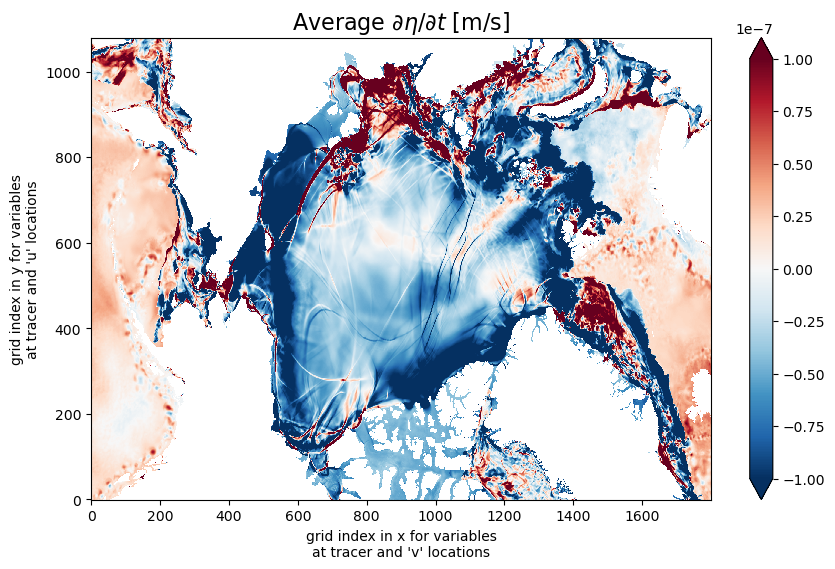

In [51]:
plt.figure(figsize=(10,6));
G_total_tendency_mean.plot(vmin=-1e-7, vmax=1e-7, cmap='RdBu_r')
plt.title('Average $\partial \eta / \partial t$ [m/s]', fontsize=16);

#### Total $\Delta \eta$

How much did `ETAN` change over this 25 day period?

In [52]:
sec_in_25_days = 25*24*60*60

In [53]:
# multiply by number of sec in 25 days to get units of meters
ETAN_delta = G_total_tendency_mean * sec_in_25_days

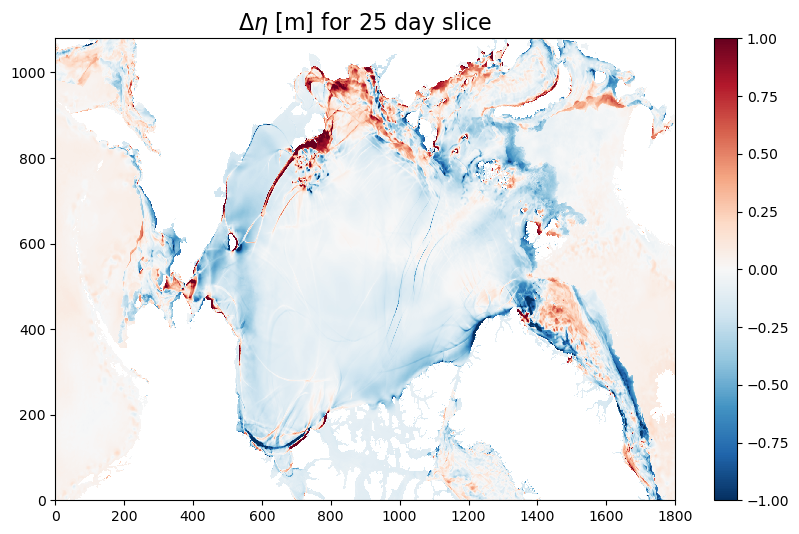

In [54]:
fig=plt.figure(figsize=(10,6))
ax=fig.add_subplot(111)
pc=ax.pcolormesh(ETAN_delta, vmin=-1, vmax=1, cmap='RdBu_r')
fig.colorbar(pc)
plt.title('$\Delta \eta$ [m] for 25 day slice', fontsize=16);

Should be the same as this:

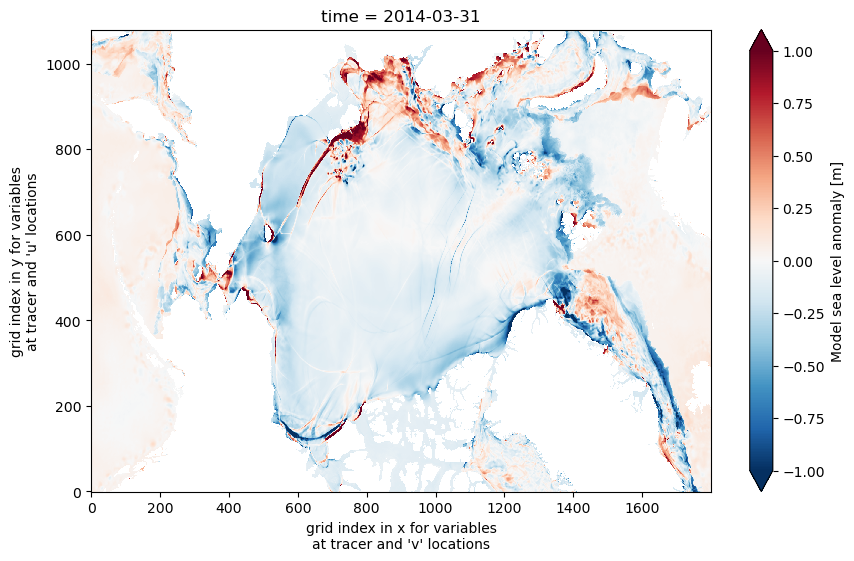

In [56]:
G_total_tendency_month.isel(time=0).plot(vmin=-1, vmax=1, cmap='RdBu_r',figsize=(10,6));

Looks good!

***

### Calculate RHS: $\eta$ tendency due to surface fluxes, $G_\text{surface fluxes}$

Surface mass fluxes are given in `oceFWflx` (units: $kgm^{-2}s^{-1}$). Convert surface mass flux to a vertical velocity (m s-1) by dividing by the reference density `rhoConst`= 1027.5 kg m-3

In [57]:
# needed to convert surface mass fluxes to volume fluxes
# Density kg/m^3
rhoconst = 1027.5

In [58]:
# tendency of eta implied by surface volume fluxes (m/s) for one 25 day slice
G_surf_fluxes = oceFWflx_slice_mean / rhoconst

In [59]:
# for one year (2019)
G_surf_fluxes_2019 = oceFWflx_slice_meanB / rhoconst

#### Plot $G_{\text{surface fluxes}}$ for the 25 day slice

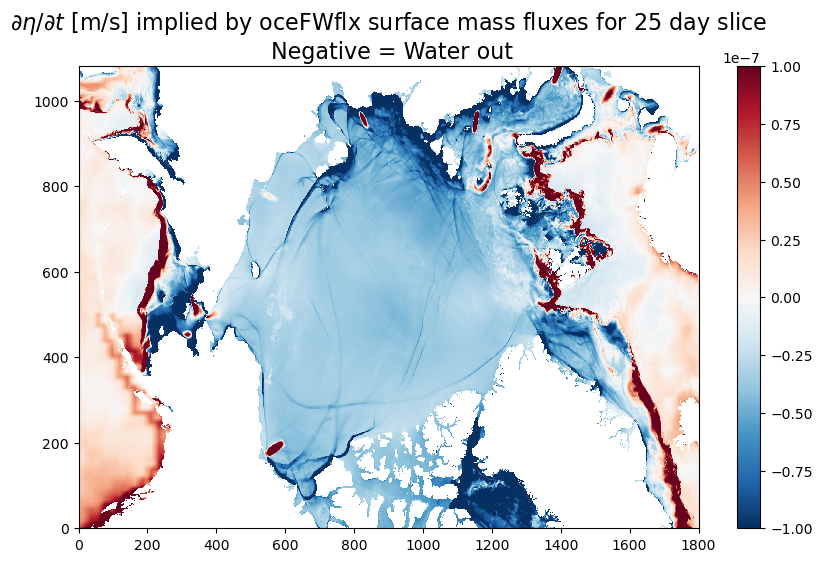

In [61]:
fig=plt.figure(figsize=(10,6))
ax=fig.add_subplot(111)
pc=ax.pcolormesh(G_surf_fluxes, vmin=-1e-7, vmax=1e-7, cmap='RdBu_r')
fig.colorbar(pc)
plt.title('$\partial \eta / \partial t$ [m/s] implied by oceFWflx surface mass fluxes for 25 day slice\n Negative = Water out', fontsize=16);

#### Plot the $G_{\text{surface fluxes}}$ for one year, 2019

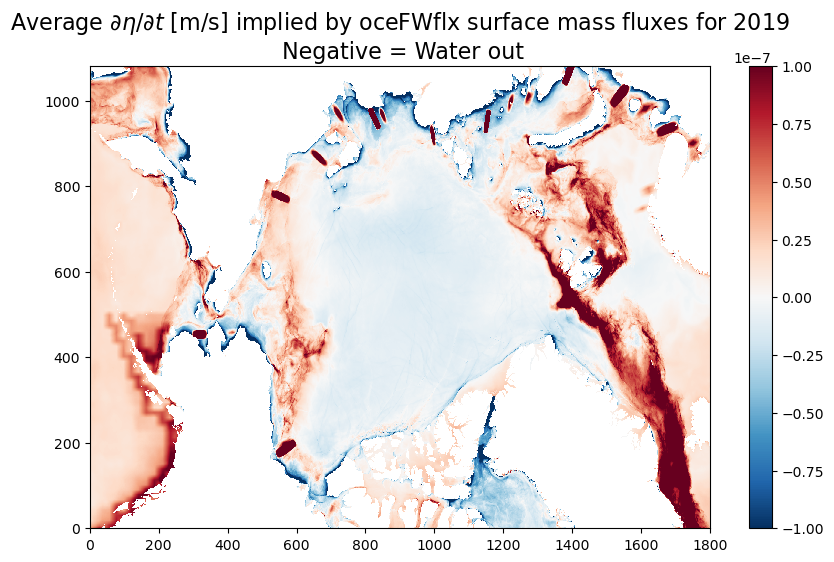

In [62]:
fig=plt.figure(figsize=(10,6))
ax=fig.add_subplot(111)
pc=ax.pcolormesh(G_surf_fluxes_2019, vmin=-1e-7, vmax=1e-7, cmap='RdBu_r')
fig.colorbar(pc)
plt.title('Average $\partial \eta / \partial t$ [m/s] implied by oceFWflx surface mass fluxes for 2019\n Negative = Water out', fontsize=16);

#### Total $\Delta \eta$ due to surface fluxes

In [63]:
ETAN_delta_surf_fluxes = G_surf_fluxes * 25 * 86400

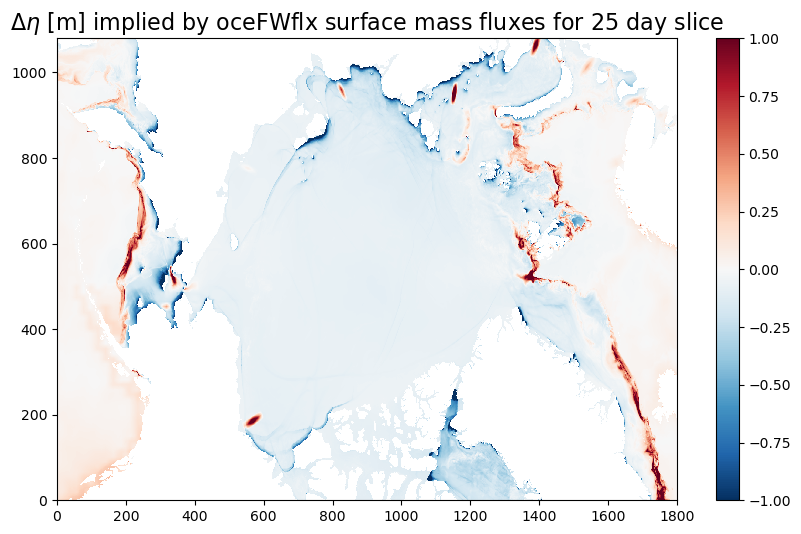

In [64]:
fig=plt.figure(figsize=(10,6))
ax=fig.add_subplot(111)
pc=ax.pcolormesh(ETAN_delta_surf_fluxes, vmin=-1, vmax=1, cmap='RdBu_r')
fig.colorbar(pc)
plt.title('$\Delta \eta$ [m] implied by oceFWflx surface mass fluxes for 25 day slice', fontsize=16);

### Calculate RHS: $\eta$ tendency due to volumetric flux divergence, $G_\text{volumetric fluxes}$

#### Horizontal Volume Flux Divergence

Calculate volumetric transports in x and y

In [65]:
# Volumetric transports in x and y (m^3/s) for 25 day snapshot

# UVEL and VVEL are in m/s. Multiply by area to get m^3/s.
vol_transport_x = UVELMASS_slice_mean * grid_ds.dyG * grid_ds.drF # length of 'west' side of grid cell (m) and grid cell thickness (m)
vol_transport_y = VVELMASS_slice_mean * grid_ds.dxG * grid_ds.drF # length of 'south' side of grid cell (m) and grid cell thickness (m)

In [66]:
# Set fluxes on land to zero (instead of NaN)
vol_transport_x = vol_transport_x.where(grid_ds.hFacW.values > 0,0)
vol_transport_y = vol_transport_y.where(grid_ds.hFacS.values > 0,0)

In [67]:
def diff_2d_flux_HH(flux_vector_dict):
    """
    A function (similar to xgcm.Grid.diff_2d_vector) that differences flux variables on the HH Arctic grid.
    """

    u_flux = flux_vector_dict['X']
    v_flux = flux_vector_dict['Y']

    u_flux_padded = u_flux.pad(pad_width={'i_g':(1,0)},mode='constant',constant_values=np.nan)
    v_flux_padded = v_flux.pad(pad_width={'j_g':(1,0)},mode='constant',constant_values=np.nan)

    # take differences
    diff_u_flux = u_flux_padded.diff('i_g')
    diff_v_flux = v_flux_padded.diff('j_g')

    # include coordinates of input DataArrays and correct dimension/coordinate names
    diff_u_flux = diff_u_flux.assign_coords(u_flux.coords).rename({'i_g':'i'})
    diff_v_flux = diff_v_flux.assign_coords(v_flux.coords).rename({'j_g':'j'})

    diff_flux_vector_dict = {'X':diff_u_flux,'Y':diff_v_flux}

    return diff_flux_vector_dict

In [68]:
# Difference of horizontal transports in x and y directions
vol_flux_diff = diff_2d_flux_HH({'X': vol_transport_x, \
                                 'Y': vol_transport_y})

In [69]:
# check padding
vol_flux_diff['X'].isel(k=0,i=0).values

array([nan, nan, nan, ..., nan, nan, nan])

In [88]:
# check padding
vol_flux_diff['Y'].isel(k=0,j=0).values

array([nan, nan, nan, ..., nan, nan, nan])

In [89]:
# volume flux divergence into each grid cell, m^3 / s
# add up x and y components
vol_horiz_divergence = (vol_flux_diff['X'] + vol_flux_diff['Y'])

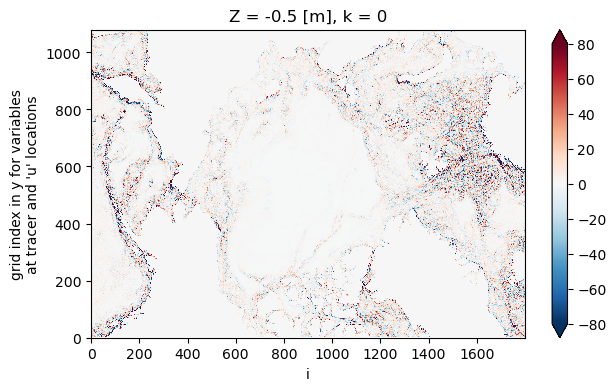

In [72]:
# plot the surface
vol_horiz_divergence.isel(k=0).plot(cmap='RdBu_r',vmin=-80,vmax=80,figsize=[7,4]);

In [73]:
# calculate change in eta per unit time due to volumetric horizonal convergence at each depth level: m/s
# divide vol_horiz_divergence (m^3/s) by area (m^2)
# a positive DIVERGENCE leads to negative eta tendency
G_vol_horiz_divergence = -vol_horiz_divergence / grid_ds.rAc

In [110]:
# change in eta in each grid cell per unit time due to horiz. divergence: m/s
# integrate across depth
G_vol_horiz_divergence_depth_integrated = G_vol_horiz_divergence.sum('k',skipna=False).compute() # skipna is set to False to retain padding as nans

In [112]:
# check that padding are still nans
print(G_vol_horiz_divergence_depth_integrated.isel(i=0).values)
print(G_vol_horiz_divergence_depth_integrated.isel(j=0).values)

[nan nan nan ... nan nan nan]
[nan nan nan ... nan nan nan]


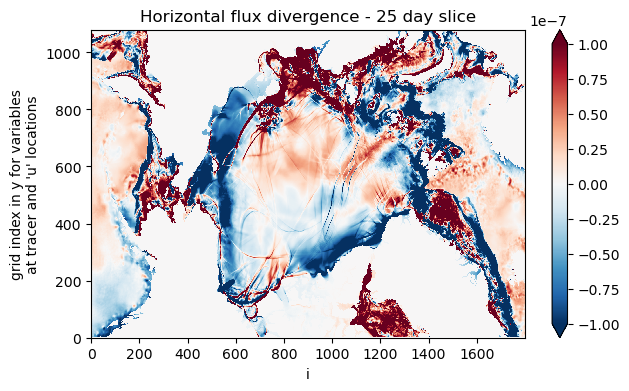

In [113]:
# plot integrated horizontal divergence for 25 day slice
G_vol_horiz_divergence_depth_integrated.plot(cmap='RdBu_r',vmin=-1e-7,vmax=1e-7,figsize=[7,4]);
plt.title("Horizontal flux divergence - 25 day slice");

***

### Closing the budget

In [115]:
# LHS ETA TENDENCY
a = G_total_tendency_mean

# RHS ETA TENDENCY FROM VOL DIVERGENCE AND SURFACE FLUXES
b = G_vol_horiz_divergence_depth_integrated
c = G_surf_fluxes

# calculate residuals
delta = a - b - c

In [122]:
# make sure padding is still nan, otherwise this will skew results
delta.isel(i=0).values

array([nan, nan, nan, ..., nan, nan, nan])

#### Plot LHS, RHS, and residuals

Plot with same colorbar scale (+/- 1e-7)

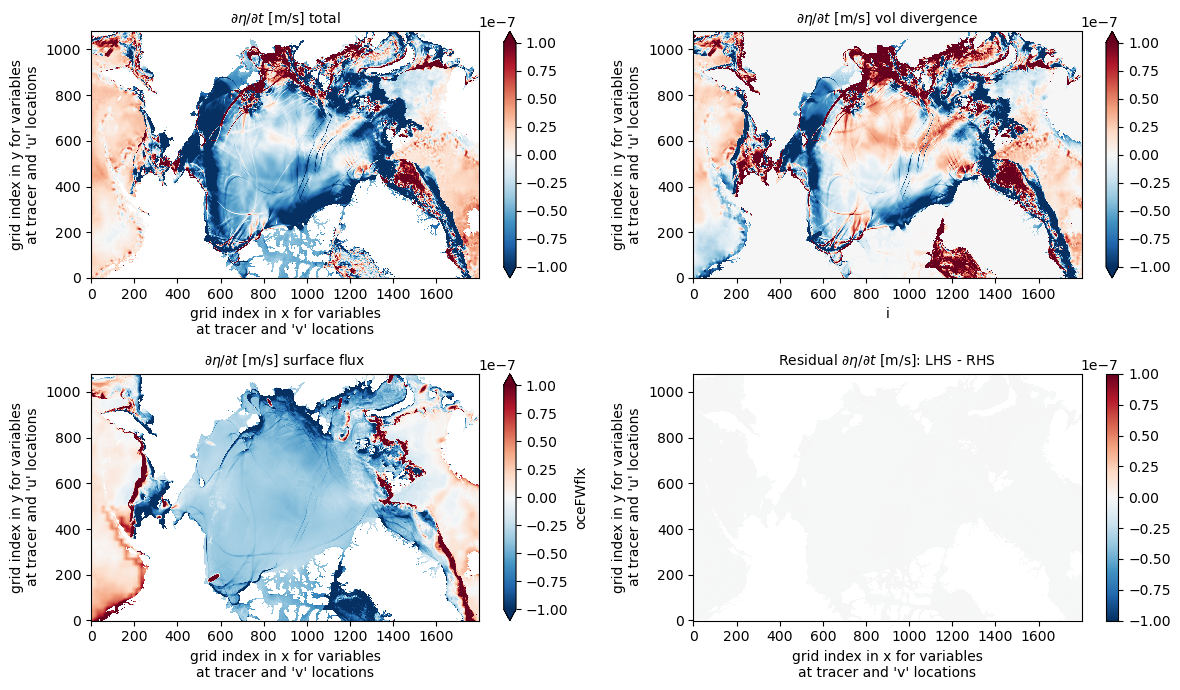

In [118]:
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=[12,7])

a.plot(ax=ax1,vmin=-1e-7,vmax=1e-7,cmap='RdBu_r')
b.plot(ax=ax2,vmin=-1e-7,vmax=1e-7,cmap='RdBu_r')
c.plot(ax=ax3,vmin=-1e-7,vmax=1e-7,cmap='RdBu_r')
delta.plot(ax=ax4,vmin=-1e-7,vmax=1e-7,cmap='RdBu_r')

ax1.set_title('$\partial \eta / \partial t$ [m/s] total',fontsize=10);
ax2.set_title('$\partial \eta / \partial t$ [m/s] vol divergence',fontsize=10);
ax3.set_title('$\partial \eta / \partial t$ [m/s] surface flux',fontsize=10);
ax4.set_title('Residual $\partial \eta / \partial t$ [m/s]: LHS - RHS ',fontsize=10);

plt.tight_layout()

The residual plot (bottom right) is essentially zero across the HH domain

#### Now plot again but with different colorbar scale for residuals (1e-9)

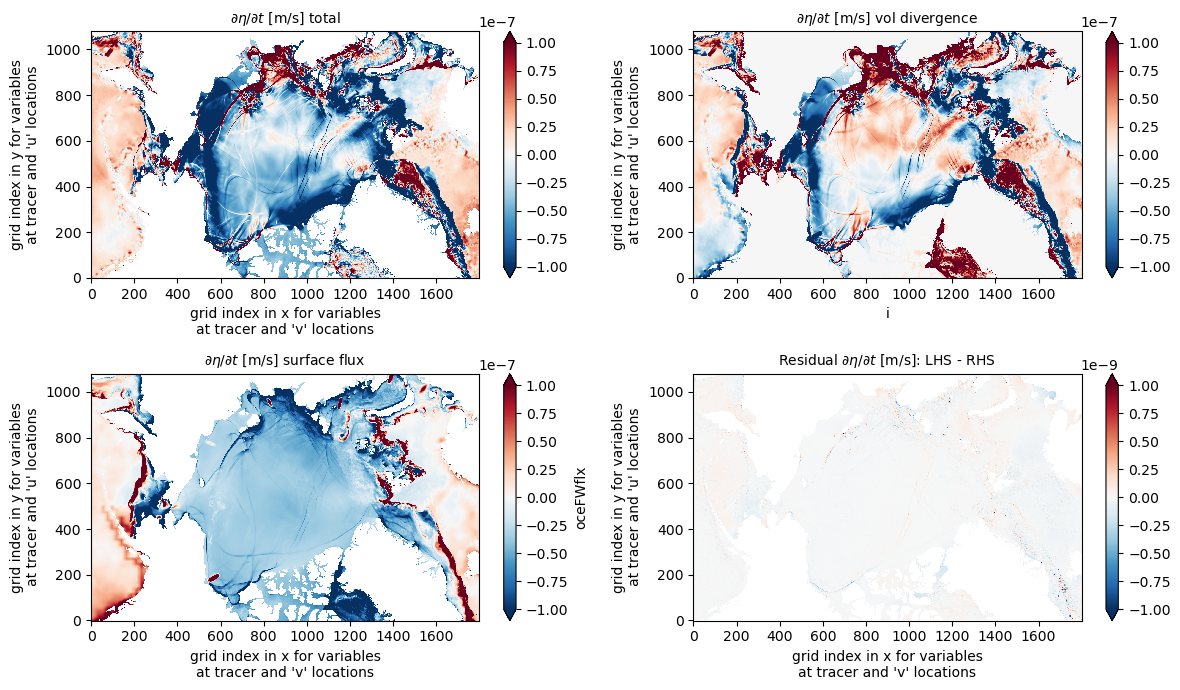

In [119]:
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=[12,7])

a.plot(ax=ax1,vmin=-1e-7,vmax=1e-7,cmap='RdBu_r')
b.plot(ax=ax2,vmin=-1e-7,vmax=1e-7,cmap='RdBu_r')
c.plot(ax=ax3,vmin=-1e-7,vmax=1e-7,cmap='RdBu_r')
delta.plot(ax=ax4,vmin=-1e-9,vmax=1e-9,cmap='RdBu_r')

ax1.set_title('$\partial \eta / \partial t$ [m/s] total',fontsize=10);
ax2.set_title('$\partial \eta / \partial t$ [m/s] vol divergence',fontsize=10);
ax3.set_title('$\partial \eta / \partial t$ [m/s] surface flux',fontsize=10);
ax4.set_title('Residual $\partial \eta / \partial t$ [m/s]: LHS - RHS ',fontsize=10);

plt.tight_layout()

#### Plot histogram of residuals

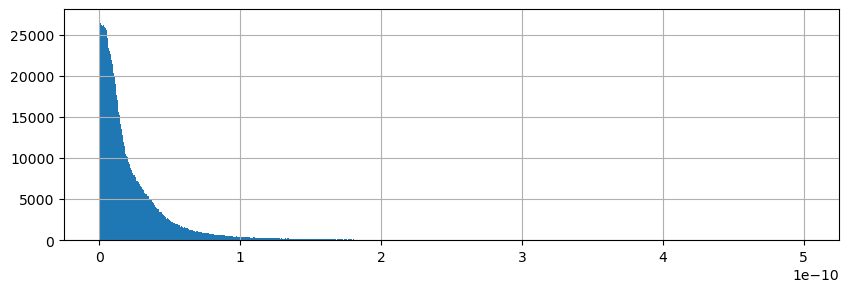

In [124]:
# take absolute value and remove nans
delta_abs = np.abs(delta).values.ravel();
resid = delta_abs[~np.isnan(delta_abs)]

plt.figure(figsize=(10,3));
plt.hist(resid,np.linspace(0,0.5e-9,1000));
plt.grid()

Most of the residuals are very close to zero, so we can close the budget.

***

### Explore different values for rhoconst to minimize residuals

#### Sweep through rhoConst from 1026-1029 by increments of 0.05 and find the one with the smallest sum of residual squared

In [125]:
rhoconst_range = np.arange(1026,1030,0.05)

In [126]:
# LHS ETA TENDENCY
a = G_total_tendency_mean

# RHS ETA TENDENCY FROM VOL DIVERGENCE AND SURFACE FLUXES
b = G_vol_horiz_divergence_depth_integrated

# create list of sum of squared residuals for each possible value of rhoconst
rss_range = []

for rhoconst in rhoconst_range:
    # calculate tendency of eta implied by surface volume fluxes (m/s)
    G_surf_fluxes = oceFWflx_slice_mean / rhoconst
    
    c = G_surf_fluxes

    # calculate residuals
    delta = a - b - c

    # square the residuals and remove nans
    sq_resid = (delta**2).values.ravel()

    # remove nans
    sq_resid_wet = sq_resid[~np.isnan(sq_resid)]
    
    # residual sum of squares
    rss = sq_resid_wet.sum()

    # append rss
    rss_range.append(rss)

In [127]:
# identify rhoconst that minimizes residual sum of squares
rss_range_min = min(rss_range)
min_index = np.argwhere(rss_range_min == rss_range)[0]
rhoconst_min = rhoconst_range[min_index]

rhoconst that minimizes residual sum of squares: [1027.45]


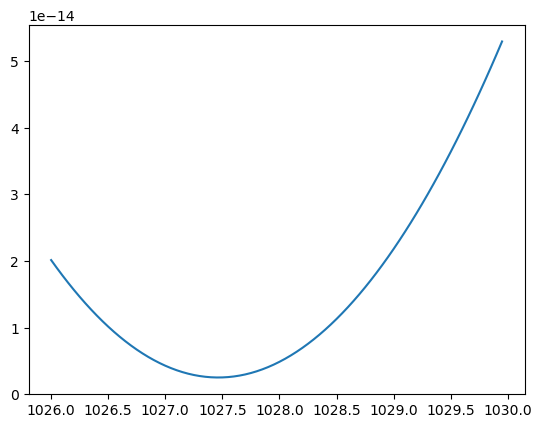

In [131]:
plt.plot(rhoconst_range, rss_range)
print(f"rhoconst that minimizes residual sum of squares: {rhoconst_min}");

***

### Appendix: compare surface WVEL with oceFWflx

#### Vertical volumetric flux divergence

`WVELMASS` at k_l=0 (the top face of the top tracer cell) should be proportional to the ocean surface mass flux `oceFWflx`. The vertical velocity of the ocean surface is equal to the rate at which water is being added or removed across the top surface of the uppermost grid cell. This is demonstrated by differencing the velocity at the top ‘w’ face of the uppermost tracr cell WVELMASS (k_l = 0) and the velocity equivalent of transporting the surface mass flux term oceFWFlx through this same face. *However, we do not see this for the LLC1080 output in the following figures.*

#### First plot example surface granules from WVELMASS and oceFWflx

Two examples for March 5, 2014

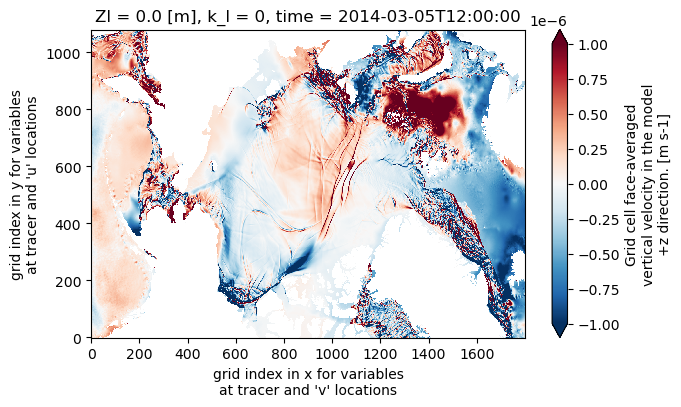

In [250]:
WVELMASS_zarr.isel(k_l=0).sel(time='2014-03-05').WVELMASS.plot(vmin=-1e-6,vmax=1e-6,cmap='RdBu_r',figsize=[7,4]);

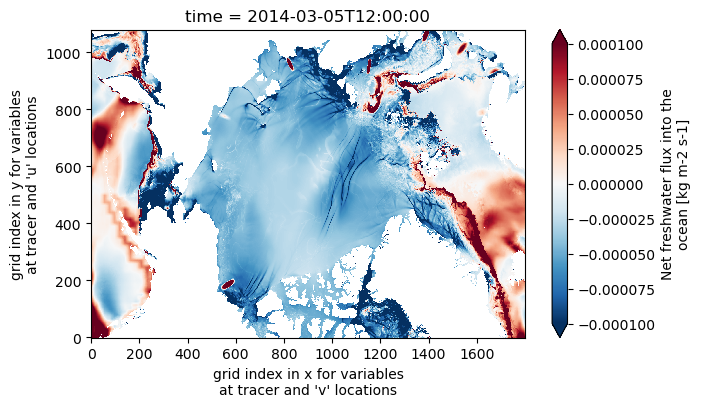

In [56]:
oceFWflx_zarr.sel(time='2014-03-05').oceFWflx.plot(vmin=-1e-4,vmax=1e-4,cmap='RdBu_r',figsize=[7,4]);

Two examples for July 5, 2014

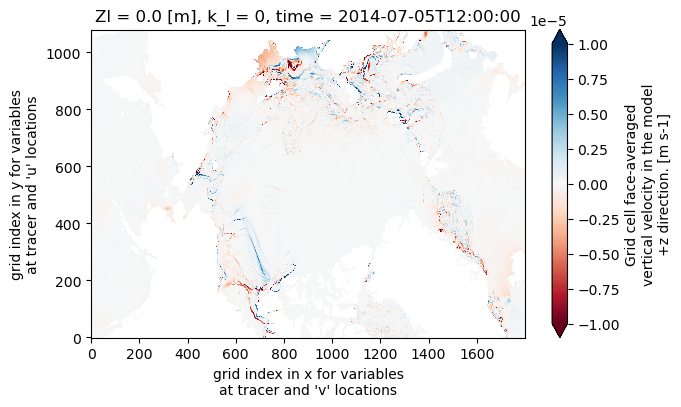

In [241]:
WVELMASS_zarr.isel(k_l=0).sel(time='2014-07-05').WVELMASS.plot(vmin=-1e-5,vmax=1e-5,cmap='RdBu',figsize=[7,4]);

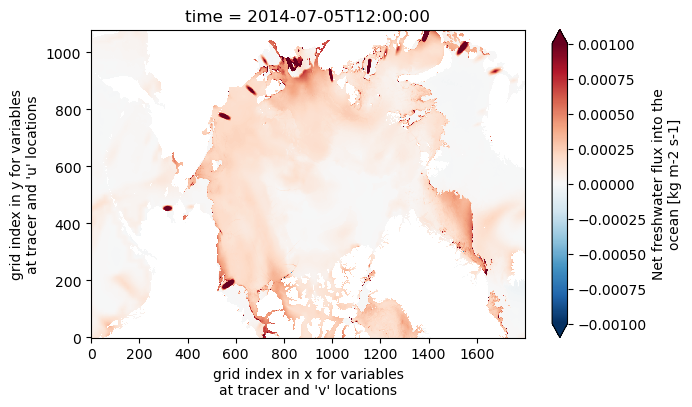

In [244]:
oceFWflx_zarr.sel(time='2014-07-05').oceFWflx.plot(vmin=-1e-3,vmax=1e-3,cmap='RdBu_r',figsize=[7,4]);

**It is clear that WVELMASS and oceFWflx do not have the same variability across HH at the surface.**

#### Next plot difference between WVELMASS and vertical velocity implied by oceFWflx

In [136]:
# select surface for WVELMASS
WVELMASS_surf_mean = WVELMASS_slice_mean.isel(k_l=0)

In [139]:
# find the time-mean vertical velocity implied by the oceFWflx at k_l=0
rhoconst = 1027.5
WVEL_from_oceFWflx_mean = -oceFWflx_slice_mean/rhoconst

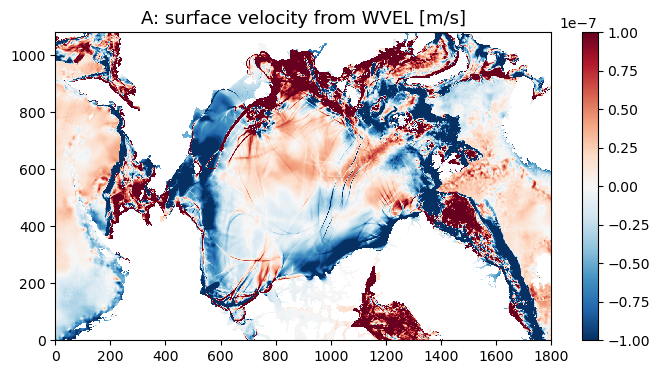

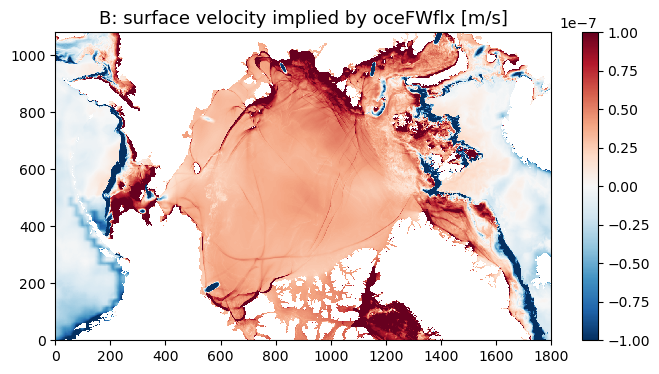

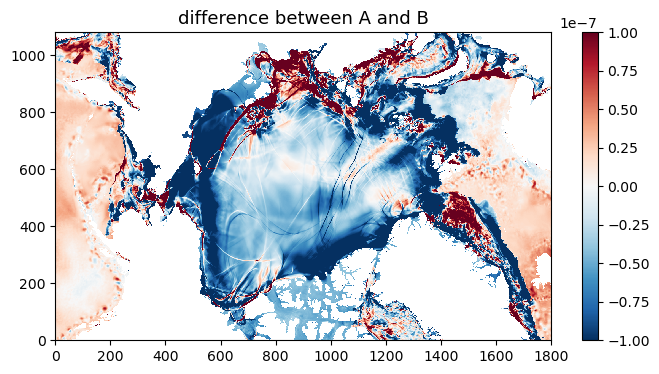

In [140]:
fig=plt.figure(figsize=(8,4))
ax=fig.add_subplot(111)
pc=ax.pcolormesh(WVELMASS_surf_mean, vmin=-1e-7, vmax=1e-7, cmap='RdBu_r')
fig.colorbar(pc)
plt.title('A: surface velocity from WVEL [m/s]', fontsize=13);

fig=plt.figure(figsize=(8,4))
ax=fig.add_subplot(111)
pc=ax.pcolormesh(WVEL_from_oceFWflx_mean, vmin=-1e-7, vmax=1e-7, cmap='RdBu_r')
fig.colorbar(pc)
plt.title("B: surface velocity implied by oceFWflx [m/s]", fontsize=13);

fig=plt.figure(figsize=(8,4))
ax=fig.add_subplot(111)
pc=ax.pcolormesh(WVELMASS_surf_mean-WVEL_from_oceFWflx_mean, vmin=-1e-7, vmax=1e-7, cmap='RdBu_r')
fig.colorbar(pc)
plt.title("difference between A and B", fontsize=13);

#### Plot some vertical profiles from WVELMASS for '2014-03-05'

Here are locations of example profiles

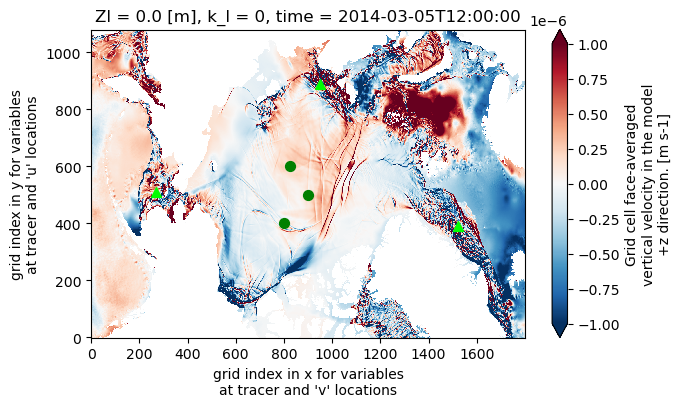

In [141]:
WVELMASS_zarr.isel(k_l=0).sel(time='2014-03-05').WVELMASS.plot(vmin=-1e-6,vmax=1e-6,cmap='RdBu_r',figsize=[7,4]);

plt.scatter(x=900,y=500,s=50,c='g')
plt.scatter(x=800,y=400,s=50,c='g')
plt.scatter(x=825,y=600,s=50,c='g')

plt.scatter(x=270, y=510,s=50,marker='^',c='lime')
plt.scatter(x=1520,y=390,s=50,marker='^',c='lime')
plt.scatter(x=950, y=890,s=50,marker='^',c='lime');

#### Somewhere quiet in the central Arctic (dark green points)

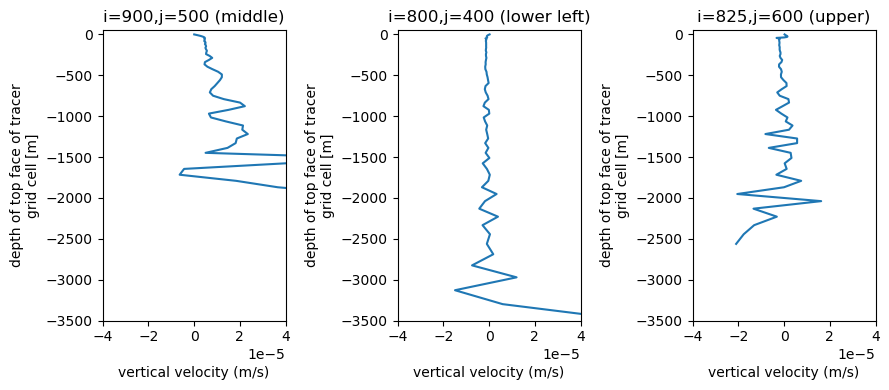

In [197]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=[9,4])

WVELMASS_zarr.isel(i=900,j=500).sel(time='2014-03-05').WVELMASS.plot(ax=ax1,y='Zl');
WVELMASS_zarr.isel(i=800,j=400).sel(time='2014-03-05').WVELMASS.plot(ax=ax2,y='Zl');
WVELMASS_zarr.isel(i=825,j=600).sel(time='2014-03-05').WVELMASS.plot(ax=ax3,y='Zl');

ax1.set_title("i=900,j=500 (middle)")
ax2.set_title("i=800,j=400 (lower left)")
ax3.set_title("i=825,j=600 (upper)")

for ax in (ax1,ax2,ax3):
    ax.set_xlim([-4e-5,4e-5])
    ax.set_ylim([-3500,50])
    ax.set_xlabel("\nvertical velocity (m/s)")

plt.tight_layout()

####  Some other points in those busy eddy regions

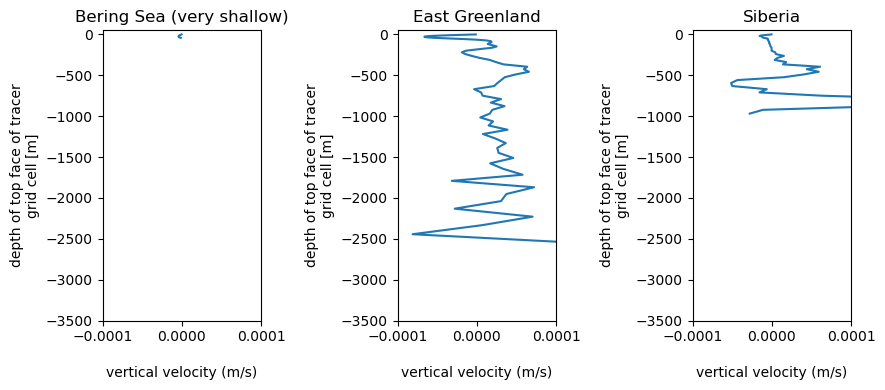

In [199]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=[9,4])

WVELMASS_zarr.isel(i=270, j=510).sel(time='2014-03-05').WVELMASS.plot(ax=ax1,y='Zl');
WVELMASS_zarr.isel(i=1520,j=390).sel(time='2014-03-05').WVELMASS.plot(ax=ax2,y='Zl');
WVELMASS_zarr.isel(i=950, j=890).sel(time='2014-03-05').WVELMASS.plot(ax=ax3,y='Zl');

ax1.set_title("Bering Sea (very shallow)")
ax2.set_title("East Greenland")
ax3.set_title("Siberia")

for ax in (ax1,ax2,ax3):
    ax.set_xlim([-10e-5,10e-5])
    ax.set_ylim([-3500,50])
    ax.set_xlabel("\nvertical velocity (m/s)")

plt.tight_layout()

###  Open examle WVEL profiles from ECCO LLC 90 V4R4

In [166]:
ecco_vol_fux_tmp = xr.open_dataset("/home/jpluser/efs-mount-point/example_sassie_netcdfs/OCEAN_3D_VOLUME_FLUX_day_mean_2014-03-05_ECCO_V4r4_native_llc0090.nc")

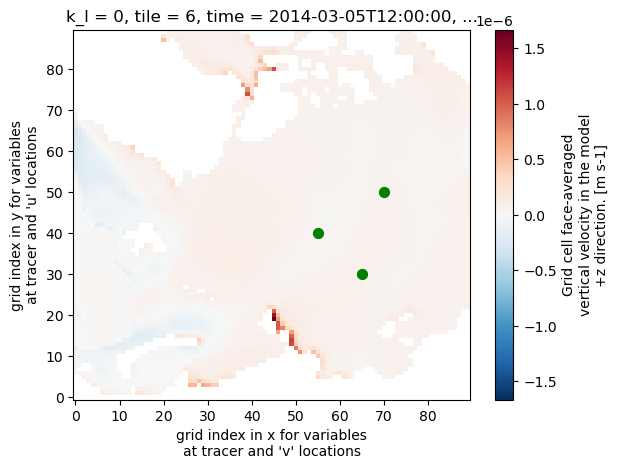

In [188]:
# look at Arctic tile first and identify a few points to plot
ecco_vol_fux_tmp.isel(tile=6,k_l=0).WVELMASS.plot()

plt.scatter(x=55,y=40,s=50,c='g')
plt.scatter(x=65,y=30,s=50,c='g')
plt.scatter(x=70,y=50,s=50,c='g');

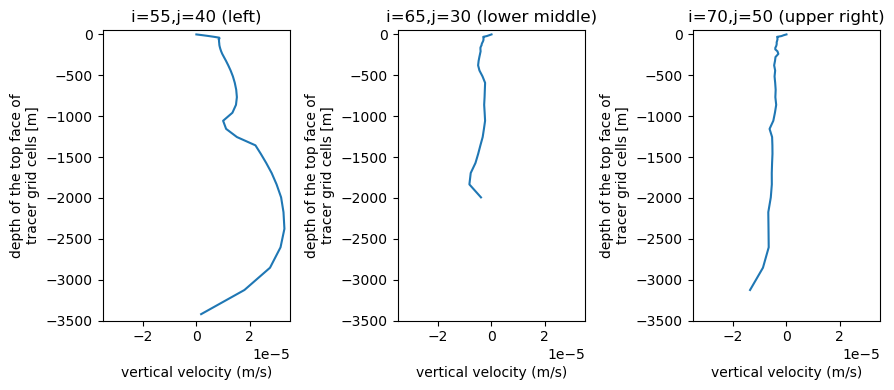

In [204]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=[9,4])

ecco_vol_fux_tmp.isel(i=55,j=40,tile=6).WVELMASS.plot(ax=ax1,y='Zl');
ecco_vol_fux_tmp.isel(i=65,j=30,tile=6).WVELMASS.plot(ax=ax2,y='Zl');
ecco_vol_fux_tmp.isel(i=70,j=50,tile=6).WVELMASS.plot(ax=ax3,y='Zl');

ax1.set_title("i=55,j=40 (left)")
ax2.set_title("i=65,j=30 (lower middle)")
ax3.set_title("i=70,j=50 (upper right)")

for ax in (ax1,ax2,ax3):
    ax.set_xlim([-3.5e-5,3.5e-5])
    ax.set_ylim([-3500,50])
    ax.set_xlabel("\nvertical velocity (m/s)")

plt.tight_layout()